In [1]:
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

In [2]:
# Function to create GeoJSON from geometry
def create_geojson(output_file, geometry, crs):
    gdf = gpd.GeoDataFrame({'geometry': [geometry]}, crs=crs)
    gdf.to_file(output_file, driver='GeoJSON')

# Function to clip raster based on GeoDataFrame
def clip_raster(input_raster, geometry, output_file):
    with rasterio.open(input_raster) as src:
        out_image, out_transform = mask(src, [geometry], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            'driver': 'GTiff',
            'height': out_image.shape[1],
            'width': out_image.shape[2],
            'transform': out_transform
        })
        with rasterio.open(output_file, 'w', **out_meta) as dest:
            dest.write(out_image)

# Function to reproject raster to target CRS
def reproject_raster(input_path, output_path, target_crs):
    with rasterio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        metadata = src.meta.copy()
        metadata.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        with rasterio.open(output_path, 'w', **metadata) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs
                )

# Function to plot raster data
def plot_raster(input_raster, output_image):
    with rasterio.open(input_raster) as src:
        data = np.log1p(src.read(1))
    plt.figure(figsize=(13, 11))
    plt.imshow(data, cmap='magma')
    plt.title('Population Density of Hungary')
    plt.axis('off')
    plt.savefig(output_image, dpi=600, bbox_inches='tight')

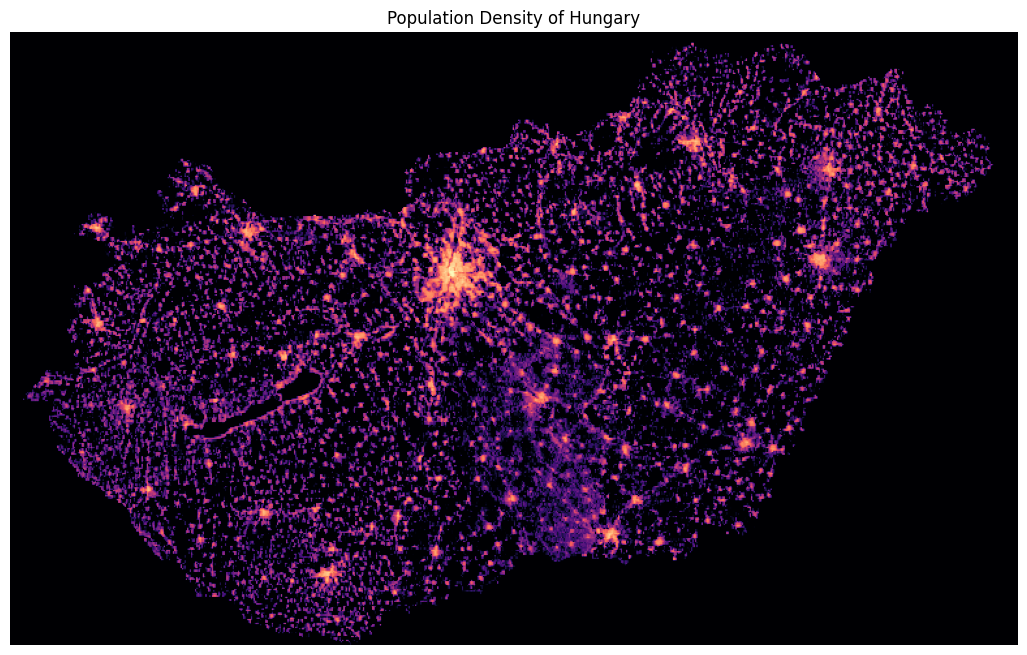

In [3]:
# Load Hungary geometry
hungary_shapefile = 'ne_10m_admin_0_countries.shp'
raster_file = 'GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0.tif'
hungary_raster = 'hungary_population.tif'

# Filter for Hungary and create GeoJSON
hungary_gdf = gpd.read_file(hungary_shapefile)
hungary_geom = hungary_gdf[hungary_gdf.SOVEREIGNT == 'Hungary'].geometry.unary_union
create_geojson('hungary.geojson', hungary_geom, hungary_gdf.crs)

# Clip raster directly to Hungary boundaries
clip_raster(raster_file, hungary_geom, hungary_raster)

# Reproject raster to local CRS
reprojected_raster = 'hungary_population_reprojected.tif'
reproject_raster(hungary_raster, reprojected_raster, 'EPSG:23700')

# Plot the final raster
plot_raster(reprojected_raster, 'Population_density_of_Hungary.png')